In [1]:
import traceback
import yaml
import tweepy
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import os
import tempfile
import imageio as iio
import requests

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('apikey.yml','r') as f:
    secret = yaml.safe_load(f.read())

consumer_key = secret['consumer_key']
consumer_secret = secret['consumer_secret_key']
access_token = secret['access_token']
access_token_secret = secret['access_token_secret']
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [3]:
def get_user_info(screen_name,res=None):
    user = api.get_user(screen_name=screen_name)
    if res == 'high':
        url = user.profile_image_url.replace('_normal.jpg','_400x400.jpg')
    else:
        url = user.profile_image_url
    profile_image = get_image(url)
    return user,profile_image

def get_image(profile_url):
    with tempfile.TemporaryDirectory() as tmpdirname:
        response = requests.get(profile_url)
        filepath = os.path.join(tmpdirname,'profile.jpg')
        if response.status_code == 200:
            with open(filepath,'wb') as f:
                f.write(response.content)
            image=iio.v3.imread(filepath)
            return image
        else:
            return None

In [4]:

# https://docs.tweepy.org/en/stable/api.html#tweepy.API.get_user
# API.get_user(*, user_id, screen_name, include_entities)

Elon Musk elonmusk True Chief Twit
(48, 48, 3)


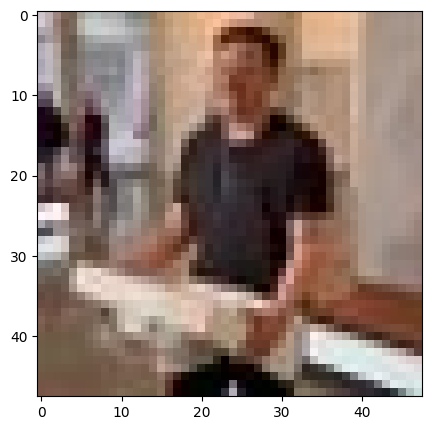

In [5]:
# @lexfridman
screen_name = 'elonmusk'
include_entities = True
user,profile_image = get_user_info(screen_name)

print(user.name,user.screen_name,user.verified,user.description)
plt.figure(figsize=(5,5))
_=plt.imshow(profile_image)
print(profile_image.shape)

In [6]:
# https://docs.tweepy.org/en/stable/api.html?highlight=search_users#tweepy.API.search_users
# API.search_users(q, *, page, count, include_entities)
# 
# page – Specifies the page of results to retrieve. Note: there are pagination limits.
# count – The number of results to try and retrieve per page.

In [45]:
# set reference image and corresponding query using `user.name`

reference_screen_name = 'elonmusk'
user,reference_image = get_user_info(screen_name)
query = user.name

print(query)

Elon Musk


In [9]:

# find  page_count*items_per_page count that matches the query
# API limit is 1k.
fetch = []
page_num = 10
count_per_page = 100

try:
    for x in range(page_num):
        print(f'querying page {x}')
        tmp = api.search_users(query,count=count_per_page,page=x)
        fetch.extend(tmp)
        if len(tmp)<count_per_page:
            break
except:
    traceback.print_exc()
    
print(len(fetch))

querying page 0
20


In [10]:
print(fetch[0])

User(_api=<tweepy.api.API object at 0x7f088a748d00>, _json={'id': 44196397, 'id_str': '44196397', 'name': 'Elon Musk', 'screen_name': 'elonmusk', 'location': 'Twitter HQ', 'description': 'Chief Twit', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 112114182, 'friends_count': 123, 'listed_count': 99916, 'created_at': 'Tue Jun 02 20:12:29 +0000 2009', 'favourites_count': 14912, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': True, 'statuses_count': 19916, 'lang': None, 'status': {'created_at': 'Sun Oct 30 12:56:06 +0000 2022', 'id': 1586703490650284032, 'id_str': '1586703490650284032', 'text': 'RT @Tesla: 20k Model Y built at Giga Texas to date! https://t.co/8Rl5ZqgqQq', 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'Tesla', 'name': 'Tesla', 'id': 13298072, 'id_str': '13298072', 'indices': [3, 9]}], 'urls': [], 'media': [{'id': 1586693915863908355, 'id_str': '15866

In [55]:

import time
# try to find a match based on profile image
mylist = []
profile_cache = {}
for n,x in enumerate(fetch):
    try:
        user,profile_image = get_user_info(x.screen_name)
        # skip item if its reference
        if user.screen_name == reference_screen_name:
            continue
        # if http error skip
        if profile_image is None:
            profile_cache[user.screen_name]=None
            continue
        # compute only if shape matches
        if profile_image.shape == reference_image.shape:
            item = dict(screen_name=user.screen_name,mean_diff=np.mean(profile_image-reference_image))
            profile_cache[user.screen_name]=profile_image.copy()
        else:
            item = dict(screen_name=user.screen_name,mean_diff=np.nan)
            profile_cache[user.screen_name]=None
        mylist.append(item)
    except:
        traceback.print_exc()
        continue

df = pd.DataFrame(mylist)
print(df.shape)

(16, 2)


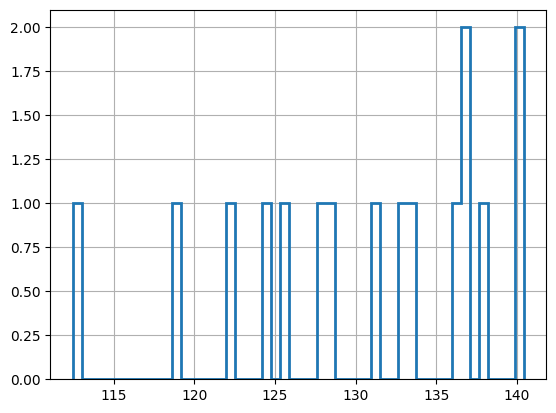

In [56]:
_=plt.hist(df.mean_diff,bins=50,histtype='step',linewidth=2)
plt.grid(True)

In [57]:
matched_df = df[df.mean_diff == 0].reset_index()
print(matched_df.shape)

(0, 3)


In [58]:
matched_df

,index,screen_name,mean_diff


In [59]:
not_matched_df = df[df.mean_diff != 0].reset_index()
not_matched_df

,index,screen_name,mean_diff
0,0,brendan_m96,140.431858
1,1,ElbitSystemsLtd,128.398872
2,2,ElonMuskNewsOrg,140.161748
3,3,BoredElonMusk,137.060619
4,4,EvilonMusk,136.333623
5,5,xoxogossipgita,136.606916
6,6,stovestoned,131.335214
7,7,sharadpandeygzp,119.185185
8,8,andItoldyaso,137.777344
9,9,glentickle,122.037471


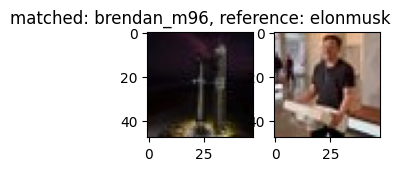

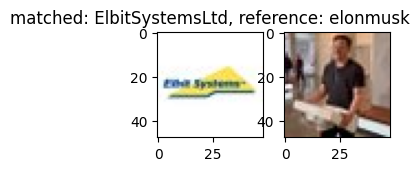

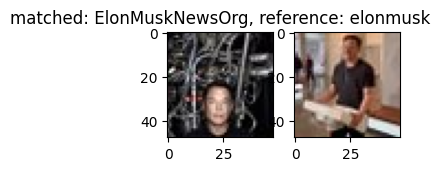

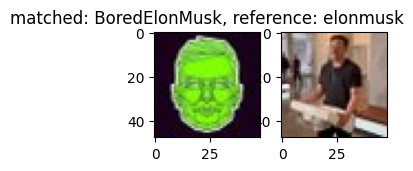

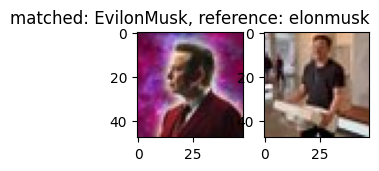

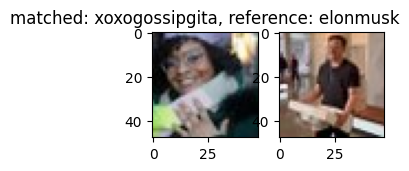

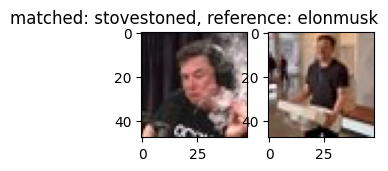

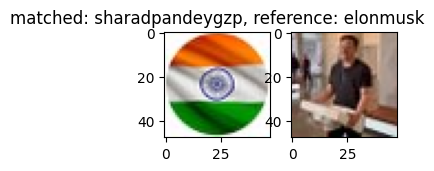

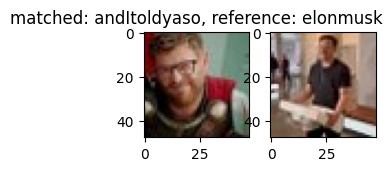

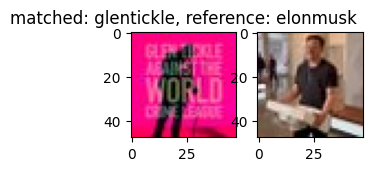

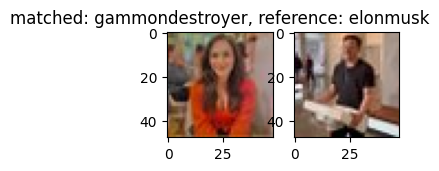

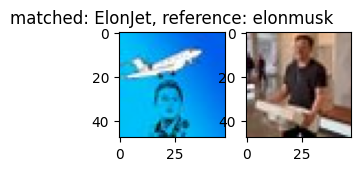

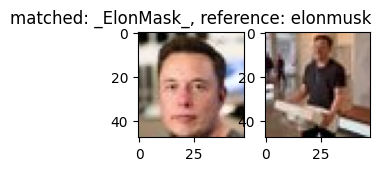

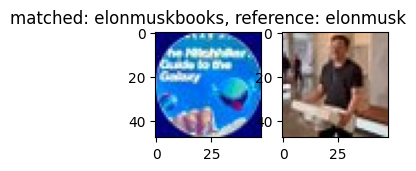

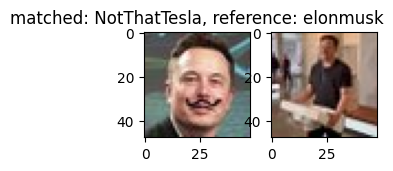

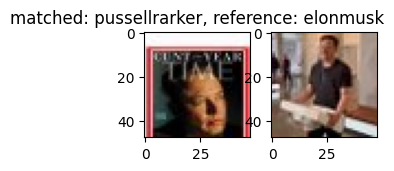

In [62]:
for n,row in not_matched_df.iterrows():
    profile_image = profile_cache[row.screen_name]
    if profile_image is None:
        continue
    plt.figure(n,figsize=(3,3))
    plt.subplot(121)
    plt.title(f'matched: {row.screen_name}, reference: {reference_screen_name}')
    plt.imshow(profile_image)
    plt.subplot(122)
    plt.imshow(reference_image)